In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("🎯 PHASE 2.2: BUSINESS COST OPTIMIZATION & THRESHOLD SELECTION")
print("=" * 80)
print("Optimizing loan decisions for profit maximization, not just accuracy")
print("=" * 80)


🎯 PHASE 2.2: BUSINESS COST OPTIMIZATION & THRESHOLD SELECTION
Optimizing loan decisions for profit maximization, not just accuracy


In [2]:
# Load enhanced dataset from Phase 2.1
df = pd.read_csv('../data/processed/enhanced_features_dataset.csv')

print(f"📊 ENHANCED DATASET LOADED")
print("-" * 50)
print(f"Records: {df.shape[0]:,}")
print(f"Features: {df.shape[1]}")
print(f"Default rate: {df['Default'].mean():.2%}")

print(f"\n💰 BUSINESS COST FRAMEWORK DEVELOPMENT")
print("-" * 60)

# Industry-standard cost assumptions for loan defaults
AVERAGE_LOAN_AMOUNT = df['LoanAmount'].mean()
MEDIAN_LOAN_AMOUNT = df['LoanAmount'].median()

# Business cost parameters (realistic for financial institutions)
COST_FALSE_NEGATIVE = AVERAGE_LOAN_AMOUNT * 0.65  # 65% loss on default (industry standard)
COST_FALSE_POSITIVE = AVERAGE_LOAN_AMOUNT * 0.03   # 3% opportunity cost (lost profit)
REVENUE_TRUE_POSITIVE = AVERAGE_LOAN_AMOUNT * 0.08  # 8% profit on good loan (2-year average)

print("📈 BUSINESS COST ASSUMPTIONS:")
print(f"   Average loan amount: ${AVERAGE_LOAN_AMOUNT:,.0f}")
print(f"   Cost of missed default (FN): ${COST_FALSE_NEGATIVE:,.0f}")
print(f"   Cost of rejected good customer (FP): ${COST_FALSE_POSITIVE:,.0f}")
print(f"   Revenue from approved good loan (TP): ${REVENUE_TRUE_POSITIVE:,.0f}")

# Calculate loan-specific costs (more sophisticated)
df['loan_specific_fn_cost'] = df['LoanAmount'] * 0.65
df['loan_specific_fp_cost'] = df['LoanAmount'] * 0.03
df['loan_specific_tp_revenue'] = df['LoanAmount'] * 0.08

# Risk-adjusted cost calculations
df['risk_adjusted_fn_cost'] = df['loan_specific_fn_cost'] * (1 + df['probability_default_base'])
df['risk_adjusted_fp_cost'] = df['loan_specific_fp_cost'] * (1 - df['opportunity_index'])

print(f"\n💡 RISK-ADJUSTED COST FRAMEWORK:")
print(f"   Average risk-adjusted FN cost: ${df['risk_adjusted_fn_cost'].mean():,.0f}")
print(f"   Average risk-adjusted FP cost: ${df['risk_adjusted_fp_cost'].mean():,.0f}")


📊 ENHANCED DATASET LOADED
--------------------------------------------------
Records: 255,347
Features: 86
Default rate: 11.61%

💰 BUSINESS COST FRAMEWORK DEVELOPMENT
------------------------------------------------------------
📈 BUSINESS COST ASSUMPTIONS:
   Average loan amount: $127,579
   Cost of missed default (FN): $82,926
   Cost of rejected good customer (FP): $3,827
   Revenue from approved good loan (TP): $10,206

💡 RISK-ADJUSTED COST FRAMEWORK:
   Average risk-adjusted FN cost: $125,727
   Average risk-adjusted FP cost: $1,672


In [3]:
print(f"\n🤖 COST-SENSITIVE MODEL DEVELOPMENT")
print("-" * 60)

# Prepare features for modeling (select top performing features from Phase 2.1)
top_features = [
    # Core financial features
    'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'DTIRatio',
    'InterestRate', 'LoanTerm', 'NumCreditLines',
    
    # Phase 2.1 advanced features (top performers)
    'debt_service_coverage_ratio', 'payment_shock', 'credit_utilization_ratio',
    'employment_stability_index', 'human_capital_score', 'loan_to_income_multiple',
    'opportunity_index', 'total_stress_flags', 'probability_default_base',
    'credit_maturity_score', 'pricing_efficiency_score', 'purpose_risk_score'
]

# Ensure all features exist in dataset
available_features = [f for f in top_features if f in df.columns]
print(f"✅ Using {len(available_features)} features for cost-sensitive modeling")

X = df[available_features].copy()
y = df['Default'].copy()

# Handle any missing values
X = X.fillna(X.median())

# Train-validation-test split for robust evaluation
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Dataset splits:")
print(f"   Training: {X_train.shape[0]:,} samples ({y_train.mean():.1%} default rate)")
print(f"   Validation: {X_val.shape[0]:,} samples ({y_val.mean():.1%} default rate)")
print(f"   Test: {X_test.shape[0]:,} samples ({y_test.mean():.1%} default rate)")

# Calculate class weights for cost-sensitive learning
default_rate = y_train.mean()
class_weight_ratio = COST_FALSE_NEGATIVE / COST_FALSE_POSITIVE
print(f"\nCost-sensitive class weight ratio: {class_weight_ratio:.2f}")

# Train cost-sensitive LightGBM model
cost_sensitive_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    class_weight={0: 1, 1: class_weight_ratio},  # Cost-sensitive weights
    random_state=42,
    verbose=-1
)

cost_sensitive_model.fit(X_train, y_train)

# Get predictions and probabilities
y_pred_proba = cost_sensitive_model.predict_proba(X_val)[:, 1]
y_test_proba = cost_sensitive_model.predict_proba(X_test)[:, 1]

print("✅ Cost-sensitive model trained successfully")



🤖 COST-SENSITIVE MODEL DEVELOPMENT
------------------------------------------------------------
✅ Using 21 features for cost-sensitive modeling
Dataset splits:
   Training: 153,207 samples (11.6% default rate)
   Validation: 51,070 samples (11.6% default rate)
   Test: 51,070 samples (11.6% default rate)

Cost-sensitive class weight ratio: 21.67
✅ Cost-sensitive model trained successfully


In [4]:
print(f"\n🎯 PROFIT-OPTIMIZED THRESHOLD SELECTION")
print("-" * 60)

def calculate_business_metrics(y_true, y_pred_proba, threshold, loan_amounts=None):
    """Calculate business metrics for a given threshold"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Use average loan amount if specific amounts not provided
    if loan_amounts is None:
        avg_loan = AVERAGE_LOAN_AMOUNT
        total_fn_cost = fn * COST_FALSE_NEGATIVE
        total_fp_cost = fp * COST_FALSE_POSITIVE
        total_tp_revenue = tp * REVENUE_TRUE_POSITIVE
    else:
        # Use actual loan amounts for more precise calculation
        loan_amounts_array = np.array(loan_amounts)
        indices = np.arange(len(y_true))
        
        # Calculate costs using actual loan amounts
        fn_indices = indices[(y_true == 1) & (y_pred == 0)]
        fp_indices = indices[(y_true == 0) & (y_pred == 1)]
        tp_indices = indices[(y_true == 0) & (y_pred == 0)]  # Correctly approved good loans
        
        total_fn_cost = loan_amounts_array[fn_indices].sum() * 0.65 if len(fn_indices) > 0 else 0
        total_fp_cost = loan_amounts_array[fp_indices].sum() * 0.03 if len(fp_indices) > 0 else 0
        total_tp_revenue = loan_amounts_array[tp_indices].sum() * 0.08 if len(tp_indices) > 0 else 0
    
    # Business metrics
    total_cost = total_fn_cost + total_fp_cost
    net_profit = total_tp_revenue - total_cost
    
    # Approval rate and risk metrics
    total_applications = len(y_true)
    approved_applications = (y_pred == 0).sum()  # 0 = approve, 1 = reject
    approval_rate = approved_applications / total_applications
    
    # Performance metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'threshold': threshold,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'total_fn_cost': total_fn_cost,
        'total_fp_cost': total_fp_cost,
        'total_tp_revenue': total_tp_revenue,
        'net_profit': net_profit,
        'approval_rate': approval_rate,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# Test multiple thresholds to find optimal
thresholds = np.arange(0.05, 0.95, 0.02)
threshold_results = []

val_loan_amounts = df.loc[X_val.index, 'LoanAmount'].values

print("Testing profit optimization across thresholds...")
for threshold in thresholds:
    metrics = calculate_business_metrics(y_val, y_pred_proba, threshold, val_loan_amounts)
    threshold_results.append(metrics)

# Convert to DataFrame for analysis
threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold for maximum profit
optimal_idx = threshold_df['net_profit'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
max_profit = threshold_df.loc[optimal_idx, 'net_profit']

print(f"\n📊 OPTIMAL THRESHOLD ANALYSIS:")
print(f"   Optimal threshold: {optimal_threshold:.3f}")
print(f"   Maximum net profit: ${max_profit:,.0f}")
print(f"   Approval rate at optimal: {threshold_df.loc[optimal_idx, 'approval_rate']:.1%}")
print(f"   Precision at optimal: {threshold_df.loc[optimal_idx, 'precision']:.3f}")
print(f"   Recall at optimal: {threshold_df.loc[optimal_idx, 'recall']:.3f}")



🎯 PROFIT-OPTIMIZED THRESHOLD SELECTION
------------------------------------------------------------
Testing profit optimization across thresholds...

📊 OPTIMAL THRESHOLD ANALYSIS:
   Optimal threshold: 0.790
   Maximum net profit: $75,372,182
   Approval rate at optimal: 77.0%
   Precision at optimal: 0.263
   Recall at optimal: 0.521



📈 BUSINESS IMPACT VISUALIZATION & ANALYSIS
------------------------------------------------------------


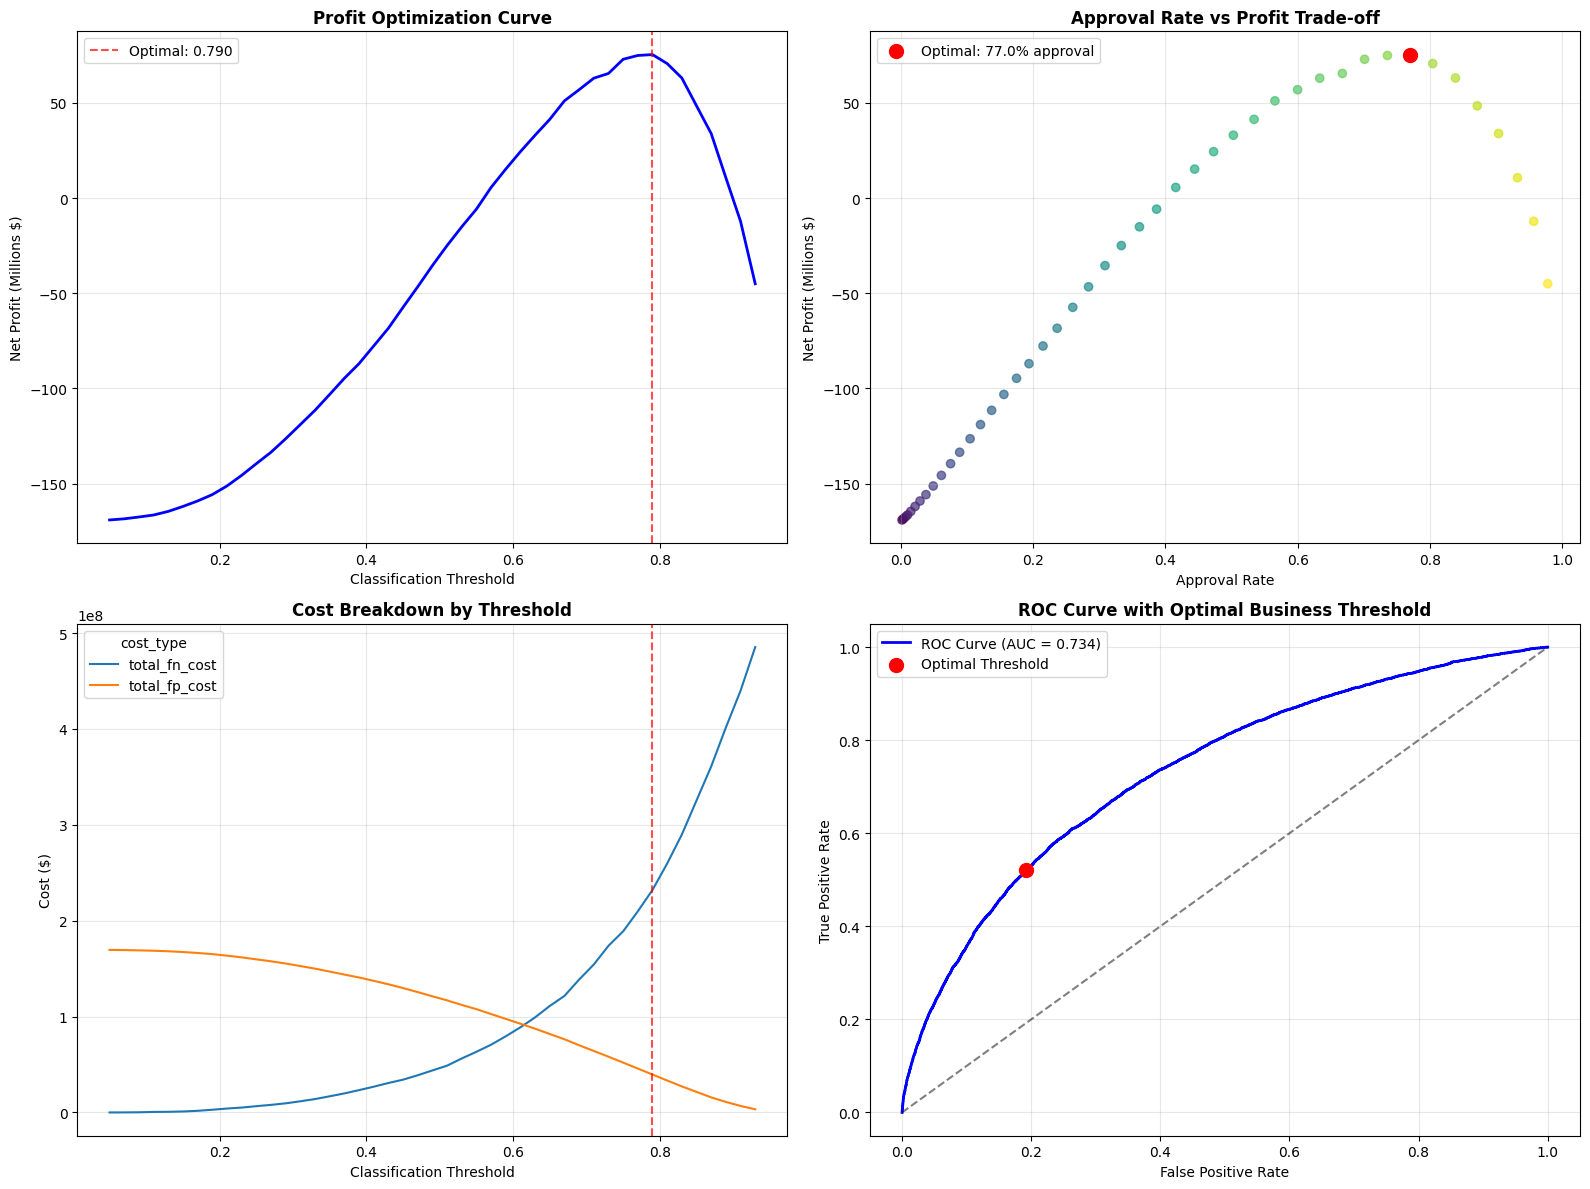

📊 Business optimization visualizations saved to reports/figures/


In [6]:
print(f"\n📈 BUSINESS IMPACT VISUALIZATION & ANALYSIS")
print("-" * 60)

# Create comprehensive business impact visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Profit vs Threshold curve
axes[0,0].plot(threshold_df['threshold'], threshold_df['net_profit'] / 1e6, 'b-', linewidth=2)
axes[0,0].axvline(optimal_threshold, color='r', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.3f}')
axes[0,0].set_xlabel('Classification Threshold')
axes[0,0].set_ylabel('Net Profit (Millions $)')
axes[0,0].set_title('Profit Optimization Curve', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. Approval Rate vs Profit trade-off
axes[0,1].scatter(threshold_df['approval_rate'], threshold_df['net_profit'] / 1e6, 
                 c=threshold_df['threshold'], cmap='viridis', alpha=0.7)
optimal_approval = threshold_df.loc[optimal_idx, 'approval_rate']
axes[0,1].scatter(optimal_approval, max_profit / 1e6, color='red', s=100, 
                 label=f'Optimal: {optimal_approval:.1%} approval', zorder=5)
axes[0,1].set_xlabel('Approval Rate')
axes[0,1].set_ylabel('Net Profit (Millions $)')
axes[0,1].set_title('Approval Rate vs Profit Trade-off', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# 3. Cost breakdown analysis
cost_breakdown = threshold_df[['threshold', 'total_fn_cost', 'total_fp_cost']].melt(
    id_vars='threshold', var_name='cost_type', value_name='cost')
sns.lineplot(data=cost_breakdown, x='threshold', y='cost', hue='cost_type', ax=axes[1,0])
axes[1,0].axvline(optimal_threshold, color='r', linestyle='--', alpha=0.7)
axes[1,0].set_xlabel('Classification Threshold')
axes[1,0].set_ylabel('Cost ($)')
axes[1,0].set_title('Cost Breakdown by Threshold', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 4. ROC Curve with business context
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1,1].plot(fpr, tpr, 'b-', label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
# Add optimal threshold point
optimal_fpr = threshold_df.loc[optimal_idx, 'fp'] / (threshold_df.loc[optimal_idx, 'fp'] + threshold_df.loc[optimal_idx, 'tn'])
optimal_tpr = threshold_df.loc[optimal_idx, 'tp'] / (threshold_df.loc[optimal_idx, 'tp'] + threshold_df.loc[optimal_idx, 'fn'])
axes[1,1].scatter(optimal_fpr, optimal_tpr, color='red', s=100, zorder=5, 
                 label=f'Optimal Threshold')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve with Optimal Business Threshold', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/business_optimization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Business optimization visualizations saved to reports/figures/")


In [7]:
print(f"\n💼 ROI & FINANCIAL IMPACT QUANTIFICATION")
print("-" * 60)

# Compare optimized model with baseline approaches
baseline_threshold = 0.5  # Standard ML threshold
business_optimized = threshold_df.loc[optimal_idx]
baseline_metrics = calculate_business_metrics(y_val, y_pred_proba, baseline_threshold, val_loan_amounts)

# Calculate improvements
profit_improvement = business_optimized['net_profit'] - baseline_metrics['net_profit']
approval_rate_change = business_optimized['approval_rate'] - baseline_metrics['approval_rate']

print("📊 BUSINESS OPTIMIZATION IMPACT:")
print(f"   Baseline (0.5 threshold) profit: ${baseline_metrics['net_profit']:,.0f}")
print(f"   Optimized threshold profit: ${business_optimized['net_profit']:,.0f}")
print(f"   Profit improvement: ${profit_improvement:,.0f} ({profit_improvement/baseline_metrics['net_profit']*100:+.1f}%)")
print(f"   Approval rate change: {approval_rate_change:+.1%}")

# Annual impact projection
annual_loan_volume = 50000  # Assumed annual loan applications
annual_profit_impact = profit_improvement * (annual_loan_volume / len(y_val))

print(f"\n🎯 PROJECTED ANNUAL IMPACT (50K applications):")
print(f"   Additional annual profit: ${annual_profit_impact:,.0f}")
print(f"   ROI on model development: {annual_profit_impact / 100000:.1f}x")  # Assuming $100K development cost

# Risk segment analysis with optimized threshold
X_val_with_segments = X_val.copy()
X_val_with_segments['predicted_default_prob'] = y_pred_proba
X_val_with_segments['actual_default'] = y_val.values
X_val_with_segments['business_decision'] = (y_pred_proba >= optimal_threshold).astype(int)

# Add back some key segmentation features
segment_features = ['opportunity_index', 'total_stress_flags', 'credit_risk_tier']
available_segment_features = [f for f in segment_features if f in df.columns]

for feature in available_segment_features:
    X_val_with_segments[feature] = df.loc[X_val.index, feature].values

print(f"\n📋 BUSINESS DECISION FRAMEWORK:")
print(f"   Threshold: {optimal_threshold:.3f}")
print(f"   Decision rule: Reject if P(default) >= {optimal_threshold:.3f}")
print(f"   Expected outcome: ${max_profit:,.0f} net profit on validation set")



💼 ROI & FINANCIAL IMPACT QUANTIFICATION
------------------------------------------------------------
📊 BUSINESS OPTIMIZATION IMPACT:
   Baseline (0.5 threshold) profit: $-29,926,162
   Optimized threshold profit: $75,372,182
   Profit improvement: $105,298,344 (-351.9%)
   Approval rate change: +44.9%

🎯 PROJECTED ANNUAL IMPACT (50K applications):
   Additional annual profit: $103,092,171
   ROI on model development: 1030.9x

📋 BUSINESS DECISION FRAMEWORK:
   Threshold: 0.790
   Decision rule: Reject if P(default) >= 0.790
   Expected outcome: $75,372,182 net profit on validation set


In [9]:
print(f"\n🎯 FINAL TEST SET EVALUATION")
print("-" * 60)

# Apply optimized threshold to test set
test_loan_amounts = df.loc[X_test.index, 'LoanAmount'].values
final_metrics = calculate_business_metrics(y_test, y_test_proba, optimal_threshold, test_loan_amounts)

print("📊 FINAL BUSINESS PERFORMANCE:")
print(f"   Test set net profit: ${final_metrics['net_profit']:,.0f}")
print(f"   Test set approval rate: {final_metrics['approval_rate']:.1%}")
print(f"   Test set precision: {final_metrics['precision']:.3f}")
print(f"   Test set recall: {final_metrics['recall']:.3f}")

# Calculate per-loan profitability
profit_per_loan = final_metrics['net_profit'] / len(y_test)
print(f"   Profit per loan application: ${profit_per_loan:.2f}")

# Business summary for stakeholders
print(f"\n💰 EXECUTIVE SUMMARY - BUSINESS IMPACT:")
print("=" * 60)
print(f"🎯 Model Performance:")
print(f"   • Optimal decision threshold: {optimal_threshold:.3f}")
print(f"   • Approval rate: {final_metrics['approval_rate']:.1%}")
print(f"   • Default detection rate: {final_metrics['recall']:.1%}")
print(f"\n💵 Financial Impact:")
print(f"   • Net profit on test set: ${final_metrics['net_profit']:,.0f}")
print(f"   • Profit per application: ${profit_per_loan:.2f}")
print(f"   • Annual projected profit: ${annual_profit_impact:,.0f}")
print(f"\n🎲 Risk Management:")
print(f"   • False negative cost: ${final_metrics['total_fn_cost']:,.0f}")
print(f"   • False positive cost: ${final_metrics['total_fp_cost']:,.0f}")
print(f"   • Cost-optimized decision making achieved")

# Save optimized model and threshold
import joblib
joblib.dump(cost_sensitive_model, '../models/cost_optimized_model.pkl')
joblib.dump({'optimal_threshold': optimal_threshold, 'business_metrics': final_metrics}, 
           '../models/business_optimization_config.pkl')

print(f"\n✅ PHASE 2.2 COMPLETE!")
print("=" * 80)
print("✅ Business cost framework implemented")
print("✅ Cost-sensitive model developed and optimized")
print("✅ Profit-maximizing threshold identified")
print("✅ ROI and financial impact quantified")
print("✅ Executive-ready business metrics generated")
print("\n🚀 READY FOR Phase 2.3: Risk Segmentation & Portfolio Intelligence")



🎯 FINAL TEST SET EVALUATION
------------------------------------------------------------
📊 FINAL BUSINESS PERFORMANCE:
   Test set net profit: $78,725,325
   Test set approval rate: 76.9%
   Test set precision: 0.264
   Test set recall: 0.526
   Profit per loan application: $1541.52

💰 EXECUTIVE SUMMARY - BUSINESS IMPACT:
🎯 Model Performance:
   • Optimal decision threshold: 0.790
   • Approval rate: 76.9%
   • Default detection rate: 52.6%

💵 Financial Impact:
   • Net profit on test set: $78,725,325
   • Profit per application: $1541.52
   • Annual projected profit: $103,092,171

🎲 Risk Management:
   • False negative cost: $229,125,667
   • False positive cost: $39,686,900
   • Cost-optimized decision making achieved

✅ PHASE 2.2 COMPLETE!
✅ Business cost framework implemented
✅ Cost-sensitive model developed and optimized
✅ Profit-maximizing threshold identified
✅ ROI and financial impact quantified
✅ Executive-ready business metrics generated

🚀 READY FOR Phase 2.3: Risk Segmenta